<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/31.00-Cenario_Rio_Experimentos.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelo individual estocástico em tempos discretos adaptado ao município do Rio de Janeiro](30.00-Cenario_Rio_comparacaocomoutrosmodelos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: distribuição inicial de infectados ->](32.00-Cenario_Rio_Distribuicao_Infectados.ipynb)

---


# Modelo individual estocástico em tempos discretos adaptado ao município do Rio de Janeiro

**Objetivos:**

- Comparar com os modelos GEMF e EON



In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import pickle

import numpy as np
from scipy import stats
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
#import episiming 
from gemfpy import GEMFPy

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 23/Jun/2020


### Comparação do mesmo cenário com o programa GEMF Na mesma rede e no mesmo

- Ver GEMFpy nos artigos

     - Sahneh, Faryad Darabi, Caterina Scoglio, and Piet Van Mieghem. "Generalized epidemic mean-field model for spreading processes over multilayer complex networks." IEEE/ACM Transactions on Networking 21.5 (2013): 1609-1620.

     - Sahneh, Faryad Darabi, et al. "GEMFsim: A stochastic simulator for the generalized epidemic modeling framework." Journal of computational science 22 (2017): 36-44.

     - Youssef, Mina, and Caterina Scoglio. "An individual-based approach to SIR epidemics in contact networks." Journal of theoretical biology 283.1 (2011): 136-144.


### Agora exibimos algumas experiências numéricas que mostram a relação da geometria da rede com o parâmetro beta

- Para isso é possível trocar uma rede individual para gerar diferentes números de contatos por nó

- E diferentes números de beta que produzem resultados semelhantes mostrando este modo a importância da geometria da rede

- Em um notebook próximo, mostrarei uma proposta de rede de controle de indivíduos uma distribuição de contatos por nó.

CPU times: user 13.4 s, sys: 693 ms, total: 14.1 s
Wall time: 17.5 s


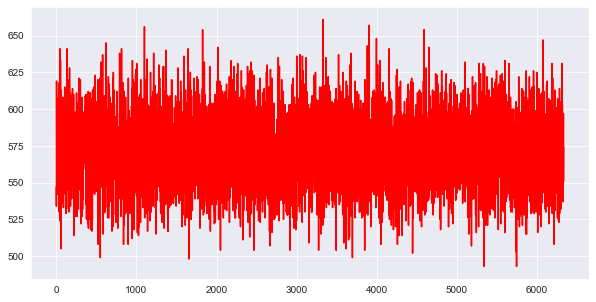

In [5]:
%%time

with open(os.path.join('..', 'input','modelos_individuais','pickle-example.p'), 'rb') as pfile:
    G = pickle.load(pfile)

N = G[0].number_of_nodes()

#Escolha do exemplo que vamos processar
case=2
#rede de individuos
#este numero define o numero de contato de cada no da rede

if case==1:
    pnodes=0.0045155
elif case==2:
    pnodes=0.045155
else:
    None
    

FG = nx.erdos_renyi_graph(N, pnodes,42,True)

nod=nx.degree(FG)
a1=[]
a2=[]
for a in nod:
    a1.append(a[0])
    a2.append(a[1])
fig34 = plt.figure(figsize=(10,5))
# for i in range(M):
plt.plot(a1, a2,'r',label='contatos por no')

### Construção da rede pegando uma rede aleatória para indivíduos e Cenário Rio para o resto das redes: residências, escolas e empressas.

In [6]:
%%time

#Estas sao as redes de residenca, escolas e empresas
#se trasnforman en redes tipo direta para combinar com as rede de indiviuos
H1 = G[0].to_directed()
H2 = G[1].to_directed()
H3 = G[2].to_directed()

CPU times: user 7.25 s, sys: 552 ms, total: 7.8 s
Wall time: 12.2 s


In [7]:
%%time

#Combina todas as redes
NetSet1=GEMFPy.MyNet(FG, weight='weight')
NetSet3=GEMFPy.MyNet(H2, weight='weight')
NetSet2=GEMFPy.MyNet(H1, weight='weight')
NetSet4=GEMFPy.MyNet(H3, weight='weight')

#mais de uma Net

NetSet=[NetSet1,NetSet2,NetSet3,NetSet4]

Net= GEMFPy.NetCmbn(NetSet)

CPU times: user 43.5 s, sys: 2.04 s, total: 45.6 s
Wall time: 52.5 s


### Simulaçoes para o modelo SEIR


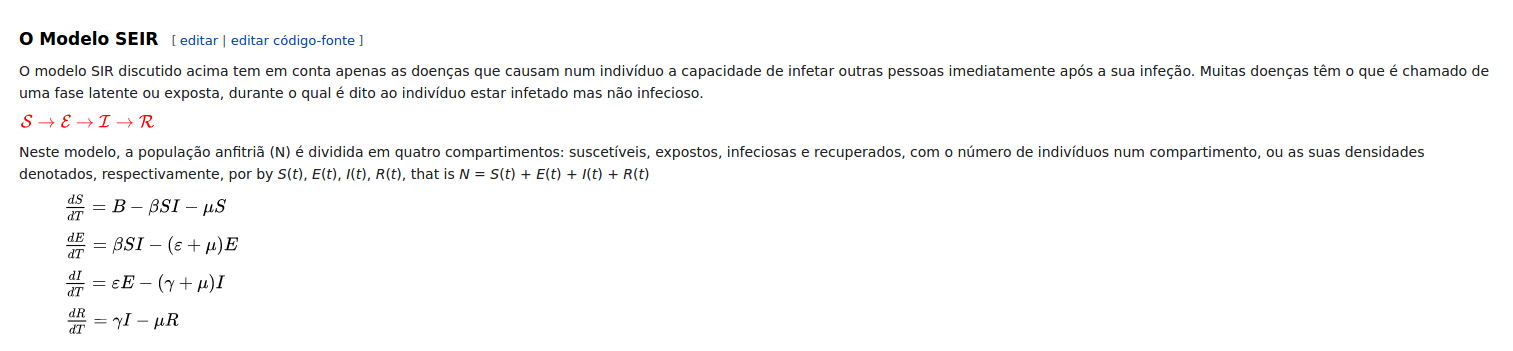

In [8]:
Image(filename=os.path.join('..','input', 'compartimentais', 'SEIR1.png'), width=2800)

### Parâmetros de base

In [9]:
num_infectados_0_base = 20 # número inicial de infectados
beta_r_base = 0.5 # taxa de contágio nas residências
beta_esc_base = 0.4 # taxa de contágio nas escolas
beta_emp_base = 0.2 # taxa de contágio no trabalho
beta_c_base = 0.2 # taxa de contágio na comunidade
gamma_base = 0.1 # inverso do tempo de recuperação

### Definição dos parâmetros e posição inicial dos indivíduos infectados

- Os numeros pnodes e beta vao definir a potencia de propagacao da epedimia

In [10]:
#parametros

if case==1:
    beta_ind=0.01
elif case==2:
    beta_ind=0.001
else:
    None

delta = gamma_base; Lambda=0.26

beta=[beta_ind,beta_r_base,beta_esc_base,beta_emp_base]

Para = GEMFPy.Para_SEIR(delta, beta, Lambda)

x0 = np.zeros(N)
x0 = GEMFPy.Initial_Cond_Gen(N, Para[1][0], 20, x0)

### Simulação para os dados acima

In [11]:
%%time
StopCond = ['RunTime', 80]

ts, n_index, i_index, j_index = GEMFPy.GEMF_SIM(Para, Net, x0, StopCond,N)

CPU times: user 56.4 s, sys: 898 ms, total: 57.3 s
Wall time: 1min 7s


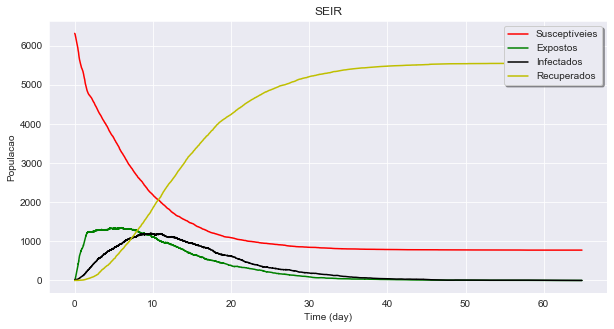

In [12]:
M = Para[0]
T, StateCount = GEMFPy.Post_Population(x0, M, N, ts, i_index, j_index)

fig = plt.figure(figsize=(10,5))
# for i in range(M):
# plt.plot(T, StateCount[0,:]/N,'r',label='Susceptible')
plt.plot(T, StateCount[0,:],'r',label='Susceptíveies')
plt.plot(T, StateCount[1,:],'g',label='Expostos')
plt.plot(T, StateCount[2,:],'k',label='Infectados')
plt.plot(T, StateCount[3,:],'y',label='Recuperados')

plt.xlabel('Time (day)')
plt.ylabel('Populacao')
plt.title('SEIR')
legend = plt.legend(loc='upper right', shadow=True)

output1 = "Case"+str(int(case)) + "beta"+str(float(beta_ind))+"proba"+ str(float(pnodes))
                                                           
plt.savefig(os.path.join('..', 'input','modelos_individuais', "Simulacao" +output1+ ".png"))

### Caso1

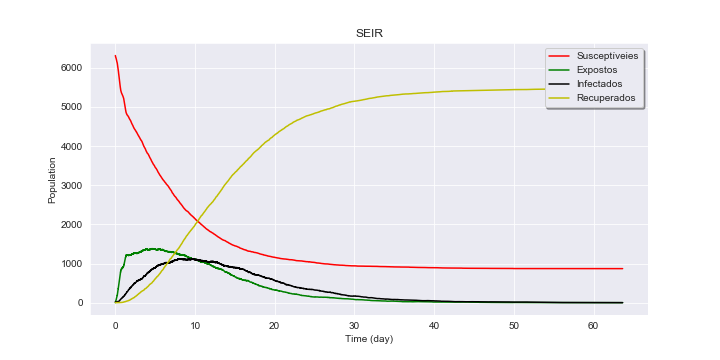

In [13]:
Image(filename=os.path.join('..', 'input','modelos_individuais', 'SimulacaoCase1beta0.01proba0.0045155.png'), width=2800)

### Caso2

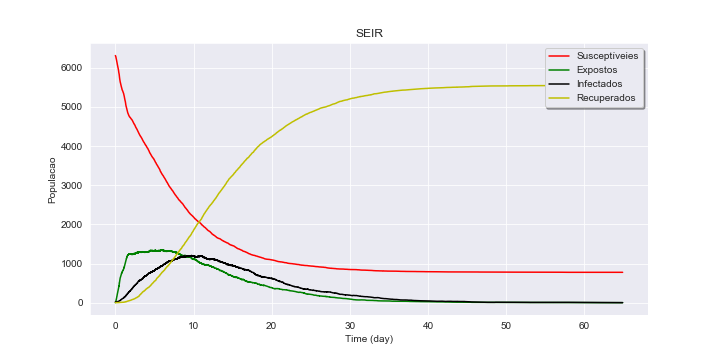

In [14]:
Image(filename=os.path.join('..', 'input','modelos_individuais', 'SimulacaoCase2beta0.001proba0.045155.png'), width=2800)

Estes dos exemplos mostra que: con diferentes numero de contados por no e parametros beta se geran resultados similares.
Isso indica que e importante estimar os dois parametros de um jeito confiavel para ter uma boa
representacao da evolucao da Epidemia

<!--NAVIGATOR-->

---
[<- Modelo individual estocástico em tempos discretos adaptado ao município do Rio de Janeiro](30.00-Cenario_Rio_comparacaocomoutrosmodelos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: distribuição inicial de infectados ->](32.00-Cenario_Rio_Distribuicao_Infectados.ipynb)